In [334]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# Load user created modules
import tools 
from model import model_class

from scipy import interpolate
import seaborn as sns

## Uncomment for nicer plots ##
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
# plt.rc('axes', axisbelow=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
np.mean(x_lognorm)

1.0104512890662782

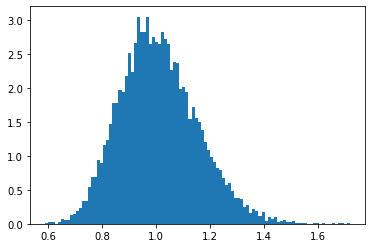

1.0111244545398301

In [192]:
# sigma2 = 0.001
# mu = -sigma2/2

x_lognorm = np.random.lognormal(model.par.mu, np.sqrt(model.par.sigma2), size = 10000) # Stochastic return rate
plt.hist(x_lognorm, density = True, bins=100)

plt.show()

np.mean(x_lognorm)


Notebook to run the .py files and visualize the results.
This is initially a simple consumption-saving model in discrete time which is solved with EGM

In [158]:
# Setup model
model = model_class()

model.setup()
model.create_grids()

**Endogenous grid**

55


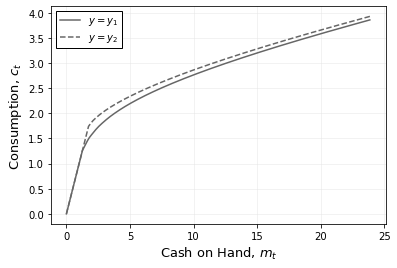

In [159]:
model.create_grids()
model.solve_egm()

# Generate figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
# ax.set_xlim([0.0,20])
# ax.set_ylim([.0,3.5])
ax.set_xlabel(r'Cash on Hand, $m_t$', size=13)
ax.set_ylabel(r'Consumption, $c_t$', size=13)

# Plot
ax.plot(model.sol_egm.m[0,:],model.sol_egm.c[0,:], label= r'$y = y_1$', linestyle = '-', color = '0.4')
ax.plot(model.sol_egm.m[1,:],model.sol_egm.c[1,:], label= r'$y = y_2$', linestyle = '--', color = '0.4')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
plt.show()

In [221]:
val = interpolate.RegularGridInterpolator([model.sol_egm.m[0,:]], model.sol_egm.c[0,:], bounds_error=False,fill_value=None)
val([20])

array([3.57973886])

## Simulate panel of households

Must draw both income levels and assert returns

In [259]:
# Construct interpolation function
c1 = interpolate.RegularGridInterpolator([model.sol_egm.m[0,:]], model.sol_egm.c[0,:], bounds_error=False,fill_value=None)
c2 = interpolate.RegularGridInterpolator([model.sol_egm.m[1,:]], model.sol_egm.c[1,:], bounds_error=False,fill_value=None)

In [272]:
# Initialize income vector
income = np.zeros(N)
r = np.random.uniform(size = N)

for i in range(len(income)):
    
    if r[i] < (1-model.par.P_22)/(2 - model.par.P_11 - model.par.P_22):
        income[i] = model.par.y1
    
    else:
        income[i] = model.par.y2

In [295]:
np.random.seed(2020)
N = 10000
T = 100
mat = np.zeros(shape=(2,N,T)) # Array to hold each consumers consumption and assets in each period

# Initialize income vector
income = np.zeros(N)
r = np.random.uniform(size = N)

for i in range(len(income)):
    
    if r[i] < (1-model.par.P_22)/(2 - model.par.P_11 - model.par.P_22):
        income[i] = model.par.y1
    
    else:
        income[i] = model.par.y2

# Loop over agents
for i in range(N):

    if income[i] == model.par.y1:
        mat[1,i,0] = 0 # Set initial assts to zero
        mat[0,i,0] = 0
    else:
        mat[1,i,0] = 0 # Set initial assts to zero
        mat[0,i,0] = 0 #model.sol_egm.c[0,0]
        
    m_next = income[i]
   
    # Loop over time periods
    for t in range(1,T):
        
        # FOR LOW INCOME
        if income[i] == model.par.y1:
            mat[1,i,t] = m_next # Assets
            mat[0,i,t] = c1([m_next]) # Consumption
            
            # Draw new income
            rand = np.random.uniform()
            if rand < model.par.P_11:
                income[i] = model.par.y1
            else:
                income[i] = model.par.y2
            
            # Draw stochastic asset return
            R = np.random.lognormal(model.par.mu, np.sqrt(model.par.sigma2))            
            
            # Compute next period assets
            m_next = R*(mat[1,i,t] - mat[0,i,t]) + income[i]
        
        # FOR HIGH INCOME
        if income[i] == model.par.y2:
            mat[1,i,t] = m_next # Assets           
            mat[0,i,t] = c2([m_next]) # Consumption
            
            # Draw new income
            rand = np.random.uniform()
            if rand < model.par.P_22:
                income[i] = model.par.y2
            else:
                income[i] = model.par.y1
            
            # Draw stochastic asset return
            R = np.random.lognormal(model.par.mu, np.sqrt(model.par.sigma2))
            
            # Compute next period assets            
            m_next = R*(mat[1,i,t] - mat[0,i,t]) + income[i]    

In [365]:
np.min(mat[1,:,T-1])

1.000000512390313

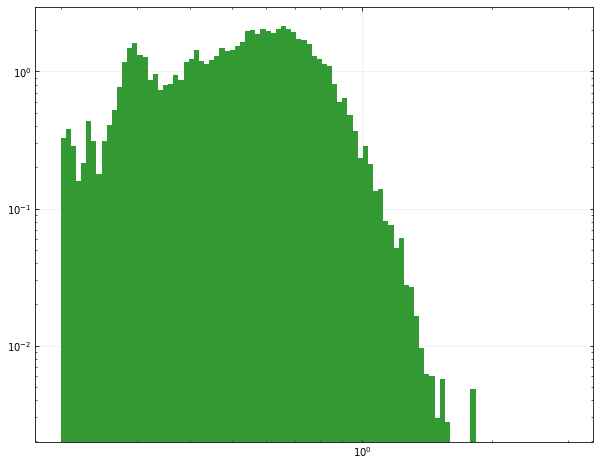

In [357]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(mat[1,:,-1] - mat[0,:,-1], density = True, bins=np.logspace(np.log10(0.2),np.log10(3.0), 100), color = 'green', alpha = 0.8, zorder = 2)
ax.set(xscale='log', yscale = 'log')


plt.show()